In [49]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
# from matplotlib.patches import Rectangle
# import pyspeckit
# import os
# from tqdm import tqdm
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
# from regions import PixCoord, RectanglePixelRegion
import take_slice
import routine
from astropy.wcs.utils import pixel_to_skycoord
import pvextractor

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

Afont = {
        'family' : 'courier new',
        'color':  'black',
        'size': 18,
        }

Afontw = {
        'family' : 'courier new',
        'color':  'white',
        'size': 18,
        }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def guesses_CO_SW(position, params):

    if position == 0.0:
        amp1 = 0.06
        vel1 = 150
        sig1 = 20
        amp2 = 0.1
        vel2 = 400
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]

        
#     elif position < 2.7:
#         guess_list = params
#         limits = [(0,0), (100,200), (0,0), (0,0), (250,400), (0,0)]
#         limited = [(False, False), (True, True), (False, False), 
#                    (False, False), (True, True), (False, False)]
        
    else:
        guess_list = params
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]
    
    return guess_list, limits, limited


def guesses_Halpha_SW(position, params):

    if position == 0.0:
        amp1 = 100
        vel1 = 200
        sig1 = 20
        amp2 = 400
        vel2 = 200
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]

        
#     elif position < 2.7:
#         guess_list = params
#         limits = [(0,0), (100,200), (0,0), (0,0), (250,400), (0,0)]
#         limited = [(False, False), (True, True), (False, False), 
#                    (False, False), (True, True), (False, False)]
        
    else:
        guess_list = params
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]
    
    return guess_list, limits, limited

Define the SW slice to be used for both CO and H-alpha.

In [51]:
length = 20
pa = 333+180  # measuring N-S
width = 10*0.3

Work with CO.

In [52]:
COfilename = '../ngc253/data/CO21_briggs_03aug2017_feather_SD1_newTP_flg_agr_vel2_09jul2018_dropsto.fits'
savepath = '../ngc253/June21/CO/SW/alma_21'
velocity_convention = 'radio'
restfreq = 230.538 * u.GHz
ContUpper = 450
ContLower = 100
x_CO_SW = 218
y_CO_SW = 157

# extract the slice and the spectra along the slice
myslice, pathCO, spectra_list, COspatial_axis_arcsec, velocity_axis = take_slice.slice_extractor(COfilename,
               x_CO_SW, y_CO_SW, length, pa, width, velocity_convention, restfreq)

# generate the text files we want
take_slice.generate_text_files(savepath)

# run the gaussian fitter to extract velocities
take_slice.velocity_extractor(savepath, guesses_CO_SW, spectra_list, COspatial_axis_arcsec, 
                   velocity_axis, ContUpper, ContLower)

# grab velocities and errors from text files
CO_vels, CO_errs = take_slice.extract_blue_velocities(savepath)

Work with bright NII line.

Take NII_vels_b, use pvextractor to slice, and then average the velocities together. Make sure to propogate errors, and save everything to new text files. Then plot both the velocities and the NII mom0 map.

In [53]:
# open the disk velocity model
disk_map_infile = '../ngc253/data/ngc253_se_halpha_vel_model_smooth_FINAL.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data

# now get NII
NIIfilename = '../ngc253/data/ADP.2018-11-22T21_29_46.157.fits'
fits2_file = '../ngc253/June21/fits2_total/fits2_reordered.txt'
ERRfits2_file = '../ngc253/June21/fits2_total/fits2_err_reordered.txt'
NII = fits.open(NIIfilename)[1]
z, y, x = NII.data.shape

x_NII_SW = 297
y_NII_SW = 246

NII_vels_b = np.empty((1, y, x)) * np.nan
NII_vels_r = np.empty((1, y, x)) * np.nan
NII_vels_outflow = np.empty((1, y, x)) * np.nan

# get the velocities
fits2 = pd.read_csv(fits2_file)
for index, row in fits2.iterrows():    
    NII_vels_b[:, int(row['Y']), int(row['X'])] = row['Vel5']
    NII_vels_r[:, int(row['Y']), int(row['X'])] = row['Vel6']

mask2_b = ((np.abs(NII_vels_b - disk_map) < np.abs(NII_vels_r - disk_map)))
mask2_r = ((np.abs(NII_vels_r - disk_map) < np.abs(NII_vels_b - disk_map)))

NII_vels_outflow[mask2_b] = NII_vels_r[mask2_b]
NII_vels_outflow[mask2_r] = NII_vels_b[mask2_r]

# ==============================================================================================================
# ==============================================================================================================

# ERRORS

ERRNII_vels_b = np.empty((1, y, x)) * np.nan
ERRNII_vels_r = np.empty((1, y, x)) * np.nan
ERRNII_vels_outflow = np.empty((1, y, x)) * np.nan
ERRfits2 = pd.read_csv(ERRfits2_file)
for index, row in ERRfits2.iterrows():
    
    ERRNII_vels_b[:, int(row['Y']), int(row['X'])] = row['rms'] # row['Vel5'] * row['rms']
    ERRNII_vels_r[:, int(row['Y']), int(row['X'])] = row['rms'] # row['Vel6'] * row['rms']

ERRNII_vels_outflow[mask2_b] = ERRNII_vels_r[mask2_b]
ERRNII_vels_outflow[mask2_r] = ERRNII_vels_b[mask2_r]

In [54]:
# extract the slice
NII_vels_cube = SpectralCube(NII_vels_outflow, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_cube.spectral_axis).to_value()

# ==============================================================================================================
# ==============================================================================================================

# ERRORS

ERRNII_vels_cube = SpectralCube(ERRNII_vels_outflow, wcs=wcs.WCS(NII))  
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_cube, path=pathNII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

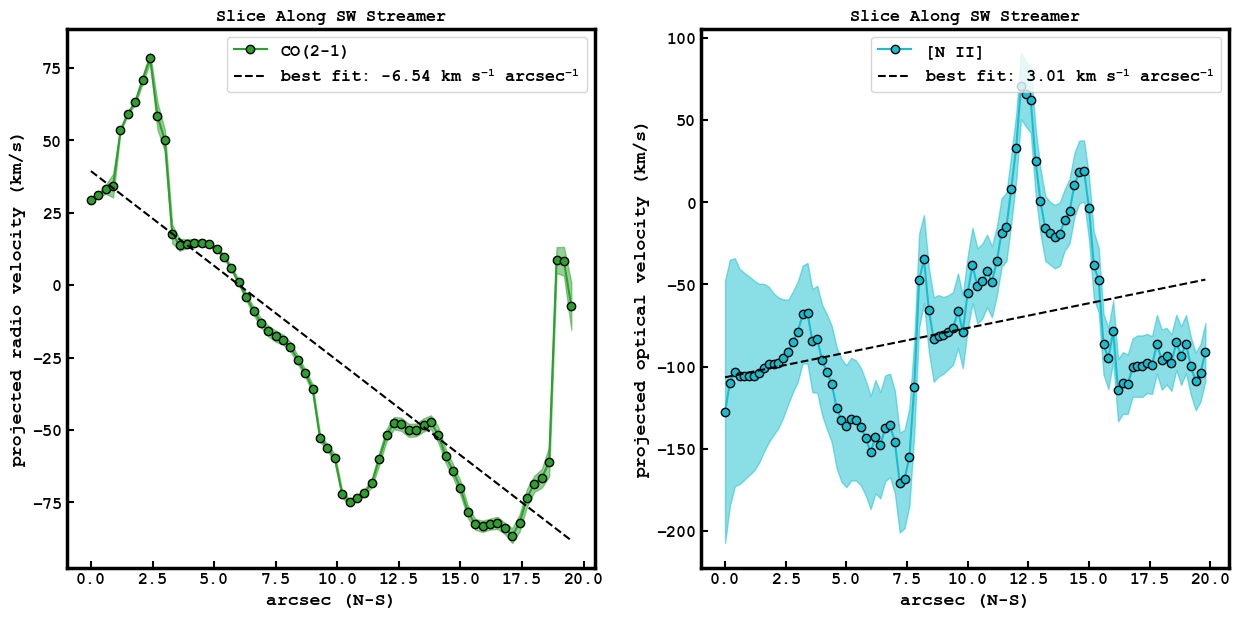

In [55]:
plt.figure(figsize=(15,7))

CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

# best fit line
m,b = np.polyfit(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')
plt.plot(COspatial_axis_arcsec, m*COspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('arcsec (N-S)', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================

NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)

# best fit line
m,b = np.polyfit(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 1)

# plot
ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('arcsec (N-S)', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
# plt.ylim(-200, 75)

plt.show()


Where are we working in the datacubes?

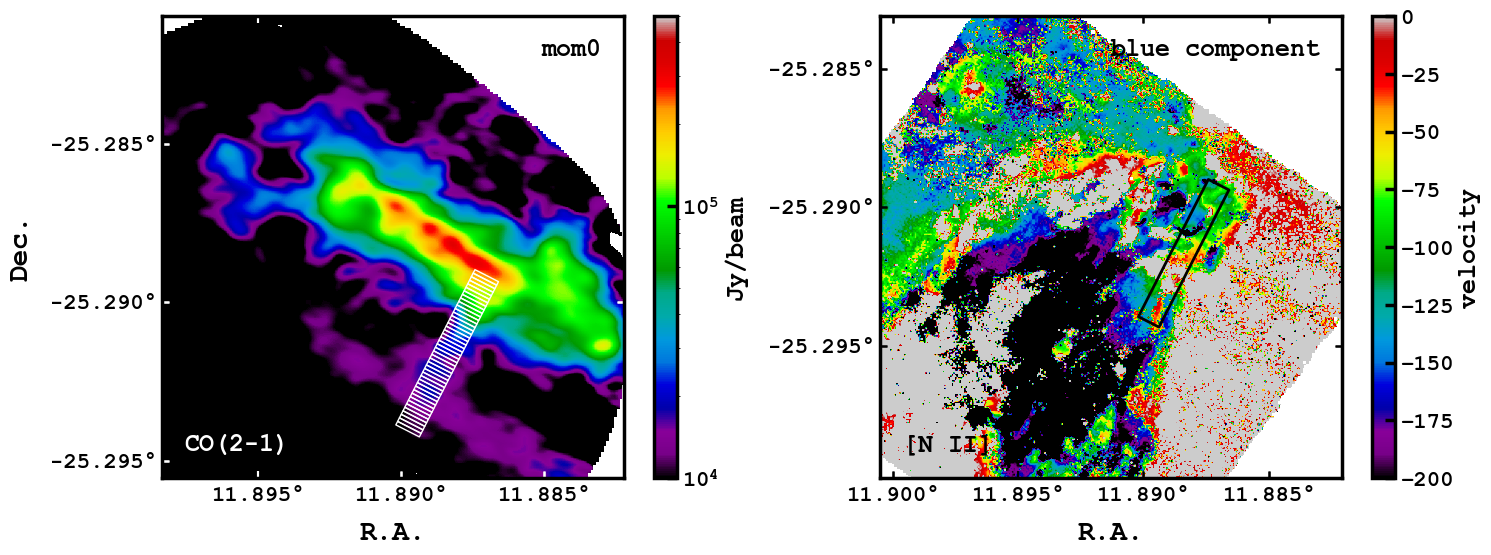

In [56]:
cmap = 'nipy_spectral'

# ============================================================================================================
# ============================================================================================================
CO21 = SpectralCube.read(COfilename)
CO21_mom0 = CO21.moment(order=0).to_value()  # moment 0
CO21w = CO21[0,:,:].wcs

plt.figure(figsize=(17,6))
ax = plt.subplot(1, 2, 1, projection=CO21w)
im = ax.imshow(CO21_mom0 / 1000, origin='lower', vmin=10000, vmax=500000, cmap=cmap, norm='log')
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.set_xlim(110,285)
ax.set_ylim(110,285)

pathCO.show_on_axis(ax, spacing=1.5, edgecolor='white', linestyle='-', linewidth=1)


bar = plt.colorbar(im, fraction=0.046)
bar.set_label('Jy/beam', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('CO(2-1)', prop=Afontw, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('mom0', prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


# ============================================================================================================
# ============================================================================================================

ax = plt.subplot(1, 2, 2, projection=wcs.WCS(NII, naxis=2))
im = ax.imshow(NII_vels_outflow[0,:,:], origin='lower', vmin=-200, vmax=0, cmap=cmap)
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.coords[1].set_auto_axislabel(False)
# ax.coords[1].set_ticklabel_visible(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xlabel('R.A.', fontsize=20)
# ax.set_ylabel('Dec.', fontsize=20)
ax.set_xlim(100,400)
ax.set_ylim(100,400)

pathNII.show_on_axis(ax, spacing=100, edgecolor='black', linestyle='-', linewidth=2)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label('velocity', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('[N II]', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('blue component', prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ============================================================================================================
# ============================================================================================================

# plt.scatter(320,280, color='black')
# plt.scatter(304,256, color='black')
# plt.scatter(288,232, color='black')
# plt.scatter(272,208, color='black')


plt.show()

Do with my map w gaps.

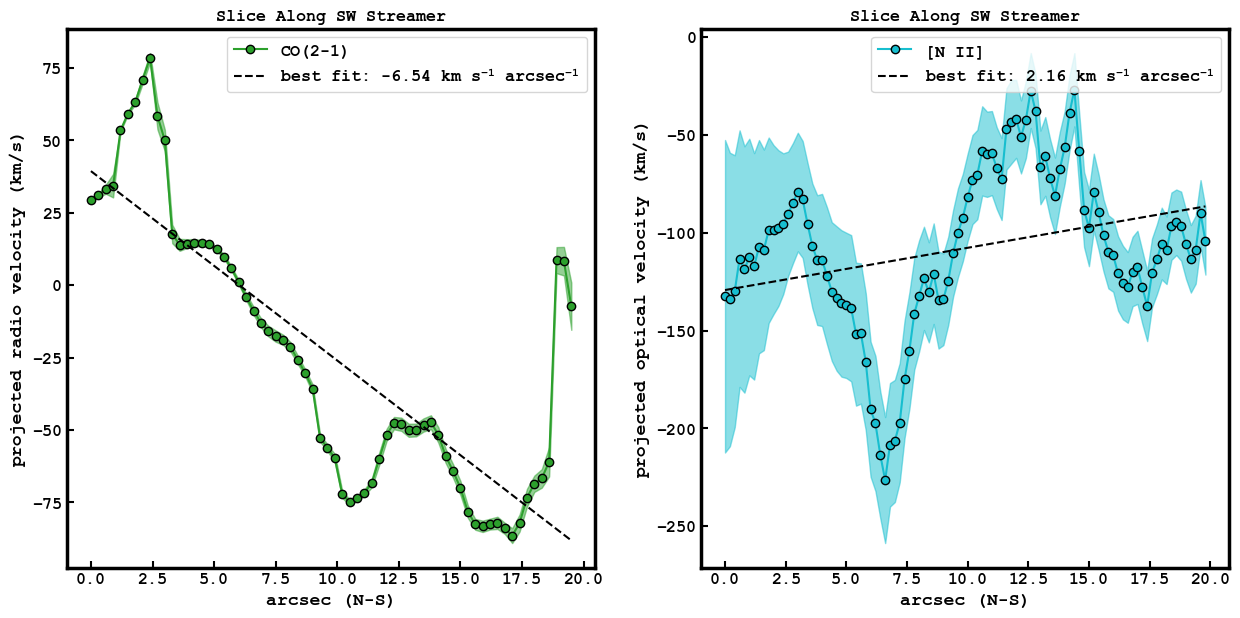

In [57]:
# extract the slice
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data


ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data


NII_vels_blue_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))
ERRNII_vels_blue_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_blue_cube, path=pathNII)
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_blue_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_blue_cube.spectral_axis).to_value()

plt.figure(figsize=(15,7))

# the velocities were measured from South to North
# to go from North to South
CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

# best fit line
m,b = np.polyfit(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')
plt.plot(COspatial_axis_arcsec, m*COspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('arcsec (N-S)', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================

NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)

# best fit line
m,b = np.polyfit(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 1)

# plot
ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('arcsec (N-S)', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
# plt.ylim(-200, 75)

plt.show()


manually stamp out 10-15 arcsec

In [58]:
NIIspatial_axis_arcsec[(NIIspatial_axis_arcsec > 10) & (NIIspatial_axis_arcsec < 15)] = np.nan

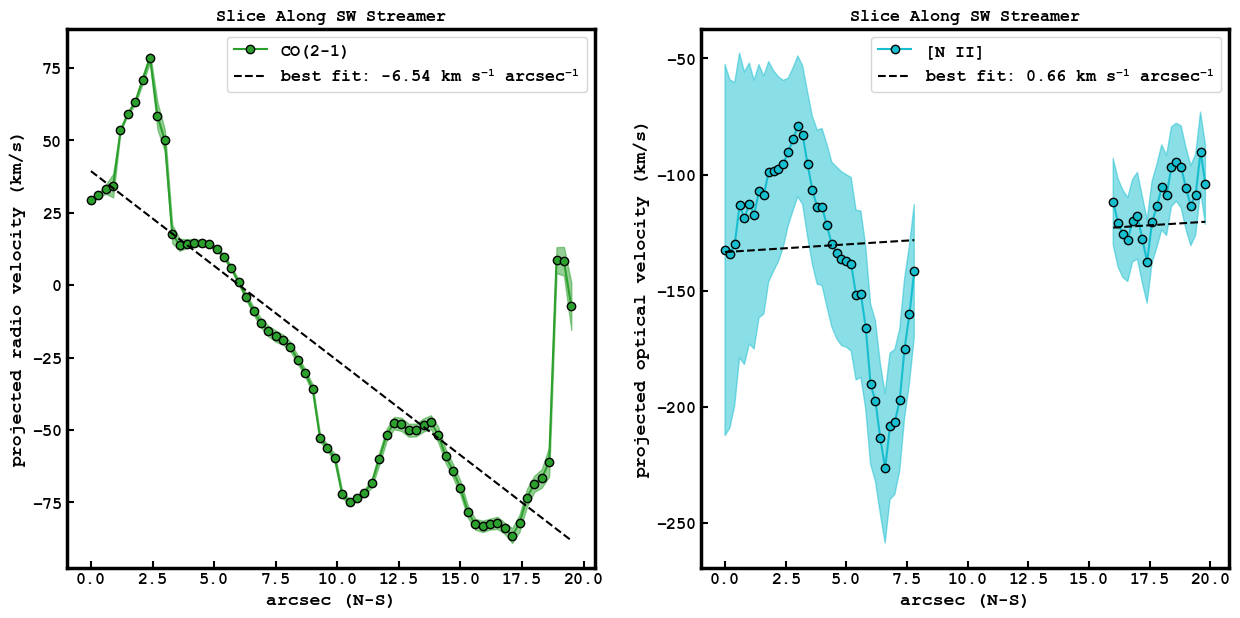

In [59]:
# extract the slice
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data


ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data


NII_vels_blue_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))
ERRNII_vels_blue_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_blue_cube, path=pathNII)
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_blue_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_blue_cube.spectral_axis).to_value()

plt.figure(figsize=(15,7))

CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

# best fit line
m,b = np.polyfit(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')
plt.plot(COspatial_axis_arcsec, m*COspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('arcsec (N-S)', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================


NIIspatial_axis_arcsec[(NIIspatial_axis_arcsec >= 8) & (NIIspatial_axis_arcsec <= 16)] = np.nan
inds = np.argwhere(~np.isnan(NIIspatial_axis_arcsec)).flatten()
NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)
m,b = np.polyfit(NIIspatial_axis_arcsec[inds], NII_sw_vels_Vsys[inds], 1)


ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('arcsec (N-S)', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
# plt.ylim(-200, 75)

plt.show()


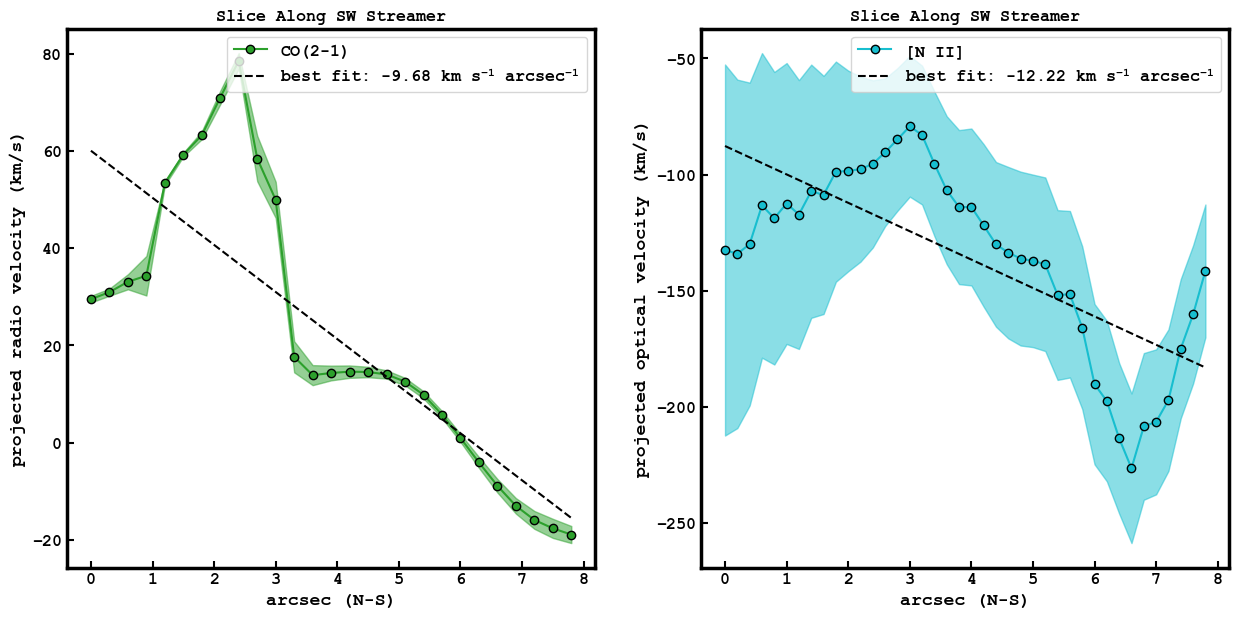

In [60]:
# extract the slice
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data
NII_vels_blue_3D.shape

ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data


NII_vels_blue_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))
ERRNII_vels_blue_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_blue_cube, path=pathNII)
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_blue_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_blue_cube.spectral_axis).to_value()

plt.figure(figsize=(15,7))

# the velocities were measured from South to North
# to go from North to South
# CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
# CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

COspatial_axis_arcsec_8 = COspatial_axis_arcsec.copy()
COspatial_axis_arcsec_8[(COspatial_axis_arcsec_8 >= 8)] = np.nan
inds = np.argwhere(~np.isnan(COspatial_axis_arcsec_8)).flatten()
CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)
m,b = np.polyfit(COspatial_axis_arcsec_8[inds], CO21_sw_vels_Vsys[inds], 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec_8, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec_8, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')
plt.plot(COspatial_axis_arcsec_8, m*COspatial_axis_arcsec_8+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('arcsec (N-S)', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================


NIIspatial_axis_arcsec[(NIIspatial_axis_arcsec >= 8)] = np.nan
inds = np.argwhere(~np.isnan(NIIspatial_axis_arcsec)).flatten()
NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)
m,b = np.polyfit(NIIspatial_axis_arcsec[inds], NII_sw_vels_Vsys[inds], 1)


ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')
plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--', label='best fit: %s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('arcsec (N-S)', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')

plt.show()


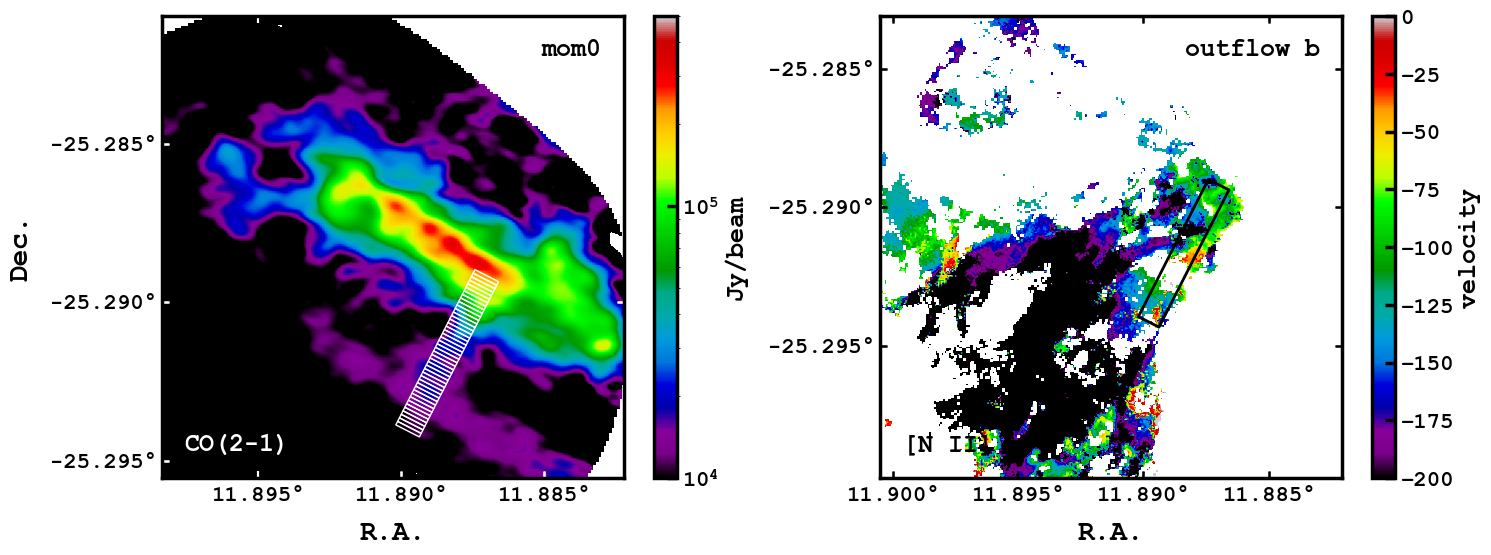

In [61]:
cmap = 'nipy_spectral'

# ============================================================================================================
# ============================================================================================================
CO21 = SpectralCube.read(COfilename)
CO21_mom0 = CO21.moment(order=0).to_value()  # moment 0
CO21w = CO21[0,:,:].wcs

plt.figure(figsize=(17,6))
ax = plt.subplot(1, 2, 1, projection=CO21w)
im = ax.imshow(CO21_mom0 / 1000, origin='lower', vmin=10000, vmax=500000, cmap=cmap, norm='log')
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='white')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.set_xlim(110,285)
ax.set_ylim(110,285)

pathCO.show_on_axis(ax, spacing=1.5, edgecolor='white', linestyle='-', linewidth=1)


bar = plt.colorbar(im, fraction=0.046)
bar.set_label('Jy/beam', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('CO(2-1)', prop=Afontw, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('mom0', prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


# ============================================================================================================
# ============================================================================================================

ax = plt.subplot(1, 2, 2, projection=wcs.WCS(NII, naxis=2))
im = ax.imshow(NII_vels_blue_3D[0,:,:], origin='lower', vmin=-200, vmax=0, cmap=cmap)
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.coords[1].set_auto_axislabel(False)
# ax.coords[1].set_ticklabel_visible(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xlabel('R.A.', fontsize=20)
# ax.set_ylabel('Dec.', fontsize=20)
ax.set_xlim(100,400)
ax.set_ylim(100,400)

pathNII.show_on_axis(ax, spacing=100, edgecolor='black', linestyle='-', linewidth=2)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label('velocity', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('[N II]', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('outflow b', prop=Afont, frameon=False, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

# ============================================================================================================
# ============================================================================================================

# plt.scatter(320,280, color='black')
# plt.scatter(304,256, color='black')
# plt.scatter(288,232, color='black')
# plt.scatter(272,208, color='black')


plt.show()

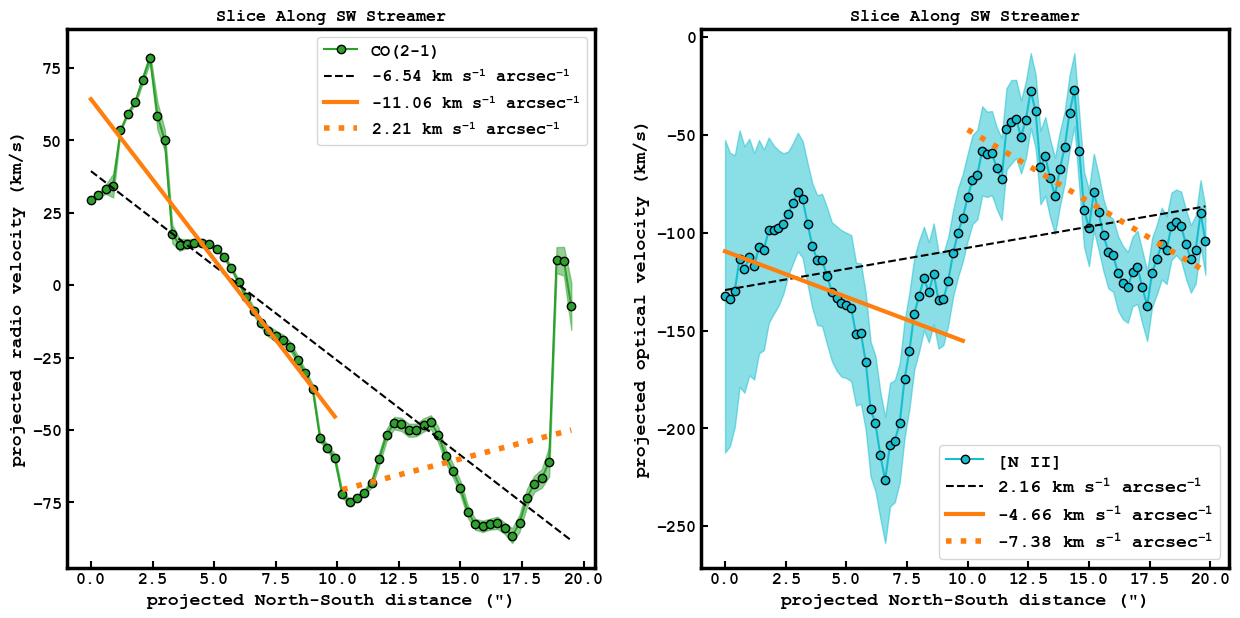

In [63]:
# extract the slice
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data


ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data


NII_vels_blue_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))
ERRNII_vels_blue_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_blue_cube, path=pathNII)
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_blue_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_blue_cube.spectral_axis).to_value()

# ============================================================================================================
# ============================================================================================================

plt.figure(figsize=(15,7))

# the velocities were measured from South to North
# to go from North to South
CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

# best fit line
m,b = np.polyfit(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 1)

# best fit up to 10 arcsec
COhalf_slice_arcsec = COspatial_axis_arcsec.copy()
COhalf_slice_arcsec[(COhalf_slice_arcsec >= 10)] = np.nan
inds10 = np.argwhere(~np.isnan(COhalf_slice_arcsec)).flatten()
m10,b10 = np.polyfit(COhalf_slice_arcsec[inds10], CO21_sw_vels_Vsys[inds10], 1)

# best fit after 10 arcsec
CO_other_half_slice_arcsec = COspatial_axis_arcsec.copy()
CO_other_half_slice_arcsec[(CO_other_half_slice_arcsec <= 10)] = np.nan
inds20 = np.argwhere(~np.isnan(CO_other_half_slice_arcsec)).flatten()
m20,b20 = np.polyfit(CO_other_half_slice_arcsec[inds20], CO21_sw_vels_Vsys[inds20], 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')

plt.plot(COspatial_axis_arcsec, m*COspatial_axis_arcsec+b, color='black', ls='--',
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))
plt.plot(COhalf_slice_arcsec[inds10], m10*COhalf_slice_arcsec[inds10]+b10, color='tab:orange', lw=3, ls='-', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m10,2))
plt.plot(CO_other_half_slice_arcsec[inds20], m20*CO_other_half_slice_arcsec[inds20]+b20, lw=4, color='tab:orange', ls=':', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m20,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('projected North-South distance (")', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================

NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)

# best fit line
m,b = np.polyfit(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 1)

# best fit up to 10 arcsec
NIIhalf_slice_arcsec = NIIspatial_axis_arcsec.copy()
NIIhalf_slice_arcsec[(NIIhalf_slice_arcsec >= 10)] = np.nan
inds10 = np.argwhere(~np.isnan(NIIhalf_slice_arcsec)).flatten()
m10,b10 = np.polyfit(NIIhalf_slice_arcsec[inds10], NII_sw_vels_Vsys[inds10], 1)

# best fit after 10 arcsec
NII_other_half_slice_arcsec = NIIspatial_axis_arcsec.copy()
NII_other_half_slice_arcsec[(NII_other_half_slice_arcsec <= 10)] = np.nan
inds20 = np.argwhere(~np.isnan(NII_other_half_slice_arcsec)).flatten()
m20,b20 = np.polyfit(NII_other_half_slice_arcsec[inds20], NII_sw_vels_Vsys[inds20], 1)

# plot
ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')

plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--',
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))
plt.plot(NIIhalf_slice_arcsec[inds10], m10*NIIhalf_slice_arcsec[inds10]+b10, color='tab:orange', lw=3, ls='-', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m10,2))
plt.plot(NII_other_half_slice_arcsec[inds20], m20*NII_other_half_slice_arcsec[inds20]+b20, lw=4, color='tab:orange', ls=':', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m20,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=13, loc='lower right')
plt.xlabel('projected North-South distance (")', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
# plt.ylim(-200, 75)

plt.show()


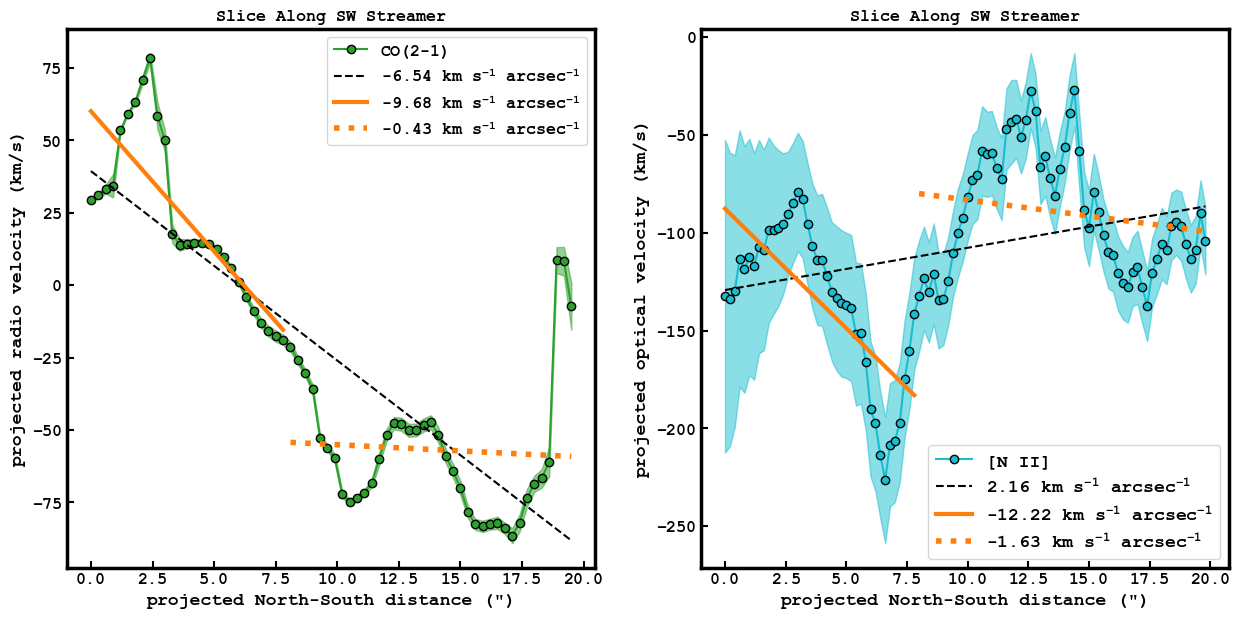

In [64]:
# extract the slice
NII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data


ERRNII_vels_blue = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
ERRNII_vels_blue_3D = np.empty((1,ERRNII_vels_blue[0].data.shape[0],ERRNII_vels_blue[0].data.shape[1]))
ERRNII_vels_blue_3D[:,:,:] = ERRNII_vels_blue[0].data


NII_vels_blue_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))
ERRNII_vels_blue_cube = SpectralCube(ERRNII_vels_blue_3D, wcs=wcs.WCS(NII))
coord = pixel_to_skycoord(x_NII_SW, y_NII_SW, wcs=wcs.WCS(NII))
pathNII = pvextractor.PathFromCenter(center=coord,
                    length=length * u.arcsec,
                    angle=pa * u.deg,
                    width=width*u.arcsec)  # 10 pixels wide    
myslice = pvextractor.extract_pv_slice(cube=NII_vels_blue_cube, path=pathNII)
ERRmyslice = pvextractor.extract_pv_slice(cube=ERRNII_vels_blue_cube, path=pathNII)


# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list = [float(myslice.data[:,i]) for i in range(myslice.shape[1])]
ERRNII_vels_list = [float(ERRmyslice.data[:,i]) for i in range(ERRmyslice.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg = wcs.WCS(myslice.header).array_index_to_world_values(np.zeros(myslice.shape[1]), np.arange(myslice.shape[1]))
NIIspatial_axis_arcsec = (NIIspatial_axis_deg[0] * u.deg).to(u.arcsec).to_value()
NIIvelocity_axis = (NII_vels_blue_cube.spectral_axis).to_value()

# ============================================================================================================
# ============================================================================================================

plt.figure(figsize=(15,7))

# the velocities were measured from South to North
# to go from North to South
CO21_sw_vels_Vsys = np.array(CO_vels) - 243.
CO21_sw_errs_Vsys = np.array(CO_errs) #- 243.)

# best fit line
m,b = np.polyfit(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 1)

# best fit up to 10 arcsec
COhalf_slice_arcsec = COspatial_axis_arcsec.copy()
COhalf_slice_arcsec[(COhalf_slice_arcsec >= 8)] = np.nan
inds10 = np.argwhere(~np.isnan(COhalf_slice_arcsec)).flatten()
m10,b10 = np.polyfit(COhalf_slice_arcsec[inds10], CO21_sw_vels_Vsys[inds10], 1)

# best fit after 10 arcsec
CO_other_half_slice_arcsec = COspatial_axis_arcsec.copy()
CO_other_half_slice_arcsec[(CO_other_half_slice_arcsec <= 8)] = np.nan
inds20 = np.argwhere(~np.isnan(CO_other_half_slice_arcsec)).flatten()
m20,b20 = np.polyfit(CO_other_half_slice_arcsec[inds20], CO21_sw_vels_Vsys[inds20], 1)

# plot
ax = plt.subplot(1,2,1)
plt.fill_between(COspatial_axis_arcsec, CO21_sw_vels_Vsys - CO21_sw_errs_Vsys, 
                 CO21_sw_vels_Vsys+CO21_sw_errs_Vsys, color='tab:green', alpha=0.5)

plt.plot(COspatial_axis_arcsec, CO21_sw_vels_Vsys, 'o-', markeredgecolor='black', label='CO(2-1)', color='tab:green')

plt.plot(COspatial_axis_arcsec, m*COspatial_axis_arcsec+b, color='black', ls='--',
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))
plt.plot(COhalf_slice_arcsec[inds10], m10*COhalf_slice_arcsec[inds10]+b10, color='tab:orange', lw=3, ls='-', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m10,2))
plt.plot(CO_other_half_slice_arcsec[inds20], m20*CO_other_half_slice_arcsec[inds20]+b20, lw=4, color='tab:orange', ls=':', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m20,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=12, loc='upper right')
plt.ylabel('projected radio velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
plt.xlabel('projected North-South distance (")', fontsize=13)

# plt.ylim(-200, 75)

# ============================================================================================================
# ============================================================================================================

NII_sw_vels_Vsys = np.array(NII_vels_list)
NII_sw_errs_Vsys = np.array(ERRNII_vels_list)

# best fit line
m,b = np.polyfit(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 1)

# best fit up to 10 arcsec
NIIhalf_slice_arcsec = NIIspatial_axis_arcsec.copy()
NIIhalf_slice_arcsec[(NIIhalf_slice_arcsec >= 8)] = np.nan
inds10 = np.argwhere(~np.isnan(NIIhalf_slice_arcsec)).flatten()
m10,b10 = np.polyfit(NIIhalf_slice_arcsec[inds10], NII_sw_vels_Vsys[inds10], 1)

# best fit after 10 arcsec
NII_other_half_slice_arcsec = NIIspatial_axis_arcsec.copy()
NII_other_half_slice_arcsec[(NII_other_half_slice_arcsec <= 8)] = np.nan
inds20 = np.argwhere(~np.isnan(NII_other_half_slice_arcsec)).flatten()
m20,b20 = np.polyfit(NII_other_half_slice_arcsec[inds20], NII_sw_vels_Vsys[inds20], 1)

# plot
ax = plt.subplot(1,2,2)

plt.fill_between(NIIspatial_axis_arcsec, NII_sw_vels_Vsys - NII_sw_errs_Vsys, 
                 NII_sw_vels_Vsys+NII_sw_errs_Vsys, color='tab:cyan', alpha=0.5)

plt.plot(NIIspatial_axis_arcsec, NII_sw_vels_Vsys, 'o-', markeredgecolor='black', label='[N II]', color='tab:cyan')

plt.plot(NIIspatial_axis_arcsec, m*NIIspatial_axis_arcsec+b, color='black', ls='--',
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m,2))
plt.plot(NIIhalf_slice_arcsec[inds10], m10*NIIhalf_slice_arcsec[inds10]+b10, color='tab:orange', lw=3, ls='-', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m10,2))
plt.plot(NII_other_half_slice_arcsec[inds20], m20*NII_other_half_slice_arcsec[inds20]+b20, lw=4, color='tab:orange', ls=':', 
         label='%s km s$^{-1}$ arcsec$^{-1}$' % round(m20,2))

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
plt.legend(fontsize=13, loc='lower right')
plt.xlabel('projected North-South distance (")', fontsize=13)
plt.ylabel('projected optical velocity (km/s)', fontsize=13)
plt.title('Slice Along SW Streamer')
# plt.ylim(-200, 75)

plt.show()
